In [1]:
import numpy as np
import os
import random
from os.path import join
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, TimeDistributed, GRU, CuDNNGRU
from keras.utils import to_categorical
from keras_utils import set_keras_session
from inception_generators import frames_generator_rnn, load_whole_dataset, sparse_frame_generator, extract_n_random_frames
from plot_utils import plot_history

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
set_keras_session()
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [3]:
frame_number = 50
width = 320
height = 240
channels = 3
padding = None

dataset_name= 'separate_frames_{}_h_{}_w_{}_inception'.format(frame_number, height, width)
if padding is not None:
    dataset_name += '_padding_{}'.format(padding)


dataset_dir = join('datasets', dataset, dataset_name)
(X_train, Y_train), (X_valid, Y_valid) = list(load_whole_dataset(dataset_dir, 'rnn', ['train', 'valid']))
sequence_shape = (frame_number, height, width, channels)
print(X_train.shape)

batch_size = 64
epochs = 100
sparse_gen = sparse_frame_generator(X_train, Y_train, 30, batch_size)
X_valid = np.array([extract_n_random_frames(video, 30) for video in X_valid])

(1126, 50, 2048)


In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras.layers import Lambda


l1l2 = regularizers.L1L2(l1=0.0, l2=0.01)

def build_model():
       
    rnn = Sequential()
    rnn.add(Dropout(0.4, input_shape=(X_valid.shape[1:])))
    rnn.add(LSTM(64, return_sequences=True, input_shape=(X_valid.shape[1:]), dropout=0.3, recurrent_dropout=0.2))
    rnn.add(Lambda(lambda x: K.mean(x, axis=1)))
    rnn.add(Dense(128, activation='relu'))
    rnn.add(Dropout(0.4))
    rnn.add(Dense(nb_classes, activation='softmax'))

    return rnn


def build_model_stacked():
       
    rnn = Sequential()
    rnn.add(LSTM(512, input_shape=(X_valid.shape[1:]), recurrent_dropout=0.2, return_sequences=True))
    rnn.add(LSTM(128, input_shape=(X_valid.shape[1:])))
    #rnn.add(Dense(128, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(nb_classes, activation='softmax'))

    return rnn

In [5]:
from keras import metrics, callbacks, optimizers
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

early_stopper = callbacks.EarlyStopping(patience=5)
reduce_lr = callbacks.ReduceLROnPlateau(patience=5, factor=0.75)

model = build_model()
print(model.summary())

sgd = optimizers.SGD(momentum=0.9, nesterov=True, lr=0.001)
# sgd = optimizers.SGD(momentum=0.9, lr=0.001)
adam = optimizers.Adam(lr=0.0001)

model.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 30, 2048)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            540928    
_________________________________________________________________
lambda_1 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1419      
Total params: 550,667
Trainable params: 550,667
Non-trainable params: 0
_________________________________________________________________
None

In [6]:
# history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), 
#           batch_size=64, epochs=500)

history = model.fit_generator(sparse_gen, steps_per_epoch=len(X_train)//batch_size, validation_data=(X_valid, Y_valid), epochs=epochs)

Epoch 1/100
17/17 [==============================] - 1s 87ms/step - loss: 2.3957 - acc: 0.1140 - top_3: 0.2987 - val_loss: 2.3550 - val_acc: 0.1194 - val_top_3: 0.3966
Epoch 2/100
17/17 [==============================] - 1s 49ms/step - loss: 2.3600 - acc: 0.1388 - top_3: 0.3667 - val_loss: 2.2938 - val_acc: 0.2729 - val_top_3: 0.5800
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 2.3117 - acc: 0.1820 - top_3: 0.4504 - val_loss: 2.2393 - val_acc: 0.3646 - val_top_3: 0.6503
Epoch 4/100
17/17 [==============================] - 1s 49ms/step - loss: 2.2631 - acc: 0.2730 - top_3: 0.5175 - val_loss: 2.1865 - val_acc: 0.4222 - val_top_3: 0.6695
Epoch 5/100
17/17 [==============================] - 1s 49ms/step - loss: 2.2168 - acc: 0.2803 - top_3: 0.5506 - val_loss: 2.1222 - val_acc: 0.4584 - val_top_3: 0.6951
Epoch 6/100
17/17 [==============================] - 1s 50ms/step - loss: 2.1543 - acc: 0.3336 - top_3: 0.6158 - val_loss: 2.0505 - val_acc: 0.4904 - val_top_3:

17/17 [==============================] - 1s 50ms/step - loss: 0.3467 - acc: 0.9035 - top_3: 0.9926 - val_loss: 0.4715 - val_acc: 0.8507 - val_top_3: 0.9787
Epoch 50/100
17/17 [==============================] - 1s 49ms/step - loss: 0.3261 - acc: 0.9182 - top_3: 0.9862 - val_loss: 0.4293 - val_acc: 0.8678 - val_top_3: 0.9744
Epoch 51/100
17/17 [==============================] - 1s 51ms/step - loss: 0.3235 - acc: 0.9228 - top_3: 0.9926 - val_loss: 0.4272 - val_acc: 0.8763 - val_top_3: 0.9744
Epoch 52/100
17/17 [==============================] - 1s 49ms/step - loss: 0.3142 - acc: 0.9219 - top_3: 0.9890 - val_loss: 0.4257 - val_acc: 0.8827 - val_top_3: 0.9744
Epoch 53/100
17/17 [==============================] - 1s 49ms/step - loss: 0.3124 - acc: 0.9200 - top_3: 0.9917 - val_loss: 0.4348 - val_acc: 0.8699 - val_top_3: 0.9744
Epoch 54/100
17/17 [==============================] - 1s 49ms/step - loss: 0.2973 - acc: 0.9210 - top_3: 0.9936 - val_loss: 0.4377 - val_acc: 0.8571 - val_top_3: 0.9723

17/17 [==============================] - 1s 50ms/step - loss: 0.1303 - acc: 0.9697 - top_3: 0.9991 - val_loss: 0.4131 - val_acc: 0.8806 - val_top_3: 0.9808
Epoch 98/100
17/17 [==============================] - 1s 50ms/step - loss: 0.1344 - acc: 0.9623 - top_3: 0.9982 - val_loss: 0.4219 - val_acc: 0.8934 - val_top_3: 0.9829
Epoch 99/100
17/17 [==============================] - 1s 50ms/step - loss: 0.1339 - acc: 0.9632 - top_3: 1.0000 - val_loss: 0.4149 - val_acc: 0.8977 - val_top_3: 0.9851
Epoch 100/100
17/17 [==============================] - 1s 50ms/step - loss: 0.1310 - acc: 0.9789 - top_3: 0.9982 - val_loss: 0.4028 - val_acc: 0.8977 - val_top_3: 0.9851


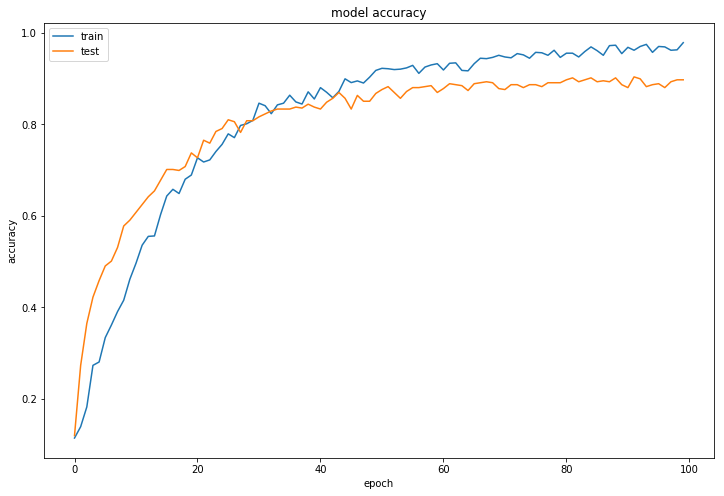

In [7]:
plot_history(history)

In [8]:
sgd = optimizers.SGD(momentum=0.9, lr=0.0005)

model.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), 
          batch_size=64, epochs=50, callbacks=[reduce_lr])

ValueError: Error when checking input: expected dropout_1_input to have shape (30, 2048) but got array with shape (50, 2048)

In [ ]:
np.set_printoptions(threshold=np.nan)
Y_predict = model.predict(X_valid)
class_predict = np.argmax(Y_predict, axis=1)
print(class_predict)

In [ ]:
class_true = np.argmax(Y_valid, axis=1)
print(class_true)

In [ ]:
for idx in range(len(class_true)):
    if class_true[idx] != class_predict[idx]:
        print(idx, 'true:', class_true[idx], '  predict:', class_predict[idx], '  prop_true:', Y_predict[idx][class_true[idx]])
        print(Y_predict[idx])
        print()

In [ ]:
from count_num_frames_on_dataset import get_number_frames_from_video
from inception_generators import get_dataset_split_structure, get_class_to_idx_dict

def dataset_loader_with_frames(dataset_dir, split_key):
    
    base_dir = join(dataset_dir, split_key)
    
    dataset_structure = get_dataset_split_structure(base_dir)
    all_classes = dataset_structure.keys()
    class_to_idx_dict = get_class_to_idx_dict(all_classes)
        
    for cl in all_classes:

        class_idx = class_to_idx_dict[cl]

        for video in dataset_structure[cl]:
            
            # ex: video == v_shooting_22_05.npy   or  video == v_walk_dog_10_01.npy
            
            video_subfolder = video[:video.rfind('_')]
            video_mpg = video[:-3] + 'mpg'
            
            original_video = join('datasets', dataset, 'video', cl, video_subfolder, video_mpg)
            number_frames = get_number_frames_from_video(original_video)

            inception_features = np.load(join(base_dir, cl, video))

            yield inception_features, class_idx, number_frames, video[:-3]
                

def load_whole_dataset_with_frames(dataset_dir, split_key):
        
    data = list(dataset_loader_with_frames(dataset_dir, split_key))
    X, Y, frames, filenames = map(np.array, zip(*data))

    yield X, to_categorical(Y), frames, filenames

In [ ]:
d = list(load_whole_dataset_with_frames(dataset_dir, 'valid'))

In [ ]:
X_valid_2, Y_valid_2, frames, filenames = zip(*d)

In [ ]:
X_valid_2, Y_valid_2, frames, filenames = X_valid_2[0], Y_valid_2[0], frames[0], filenames[0]

In [ ]:
Y_predict = model.predict(X_valid_2)
class_predict = np.argmax(Y_predict, axis=1)
print(class_predict)

In [ ]:
class_true = np.argmax(Y_valid_2, axis=1)
print(class_true)

In [ ]:
frames_incorrect = []
class_incorrect = []

for idx in range(len(class_true)):
    if class_true[idx] != class_predict[idx]:
        print(idx, 'true:', class_true[idx], '  predict:', class_predict[idx], '  prop_true:', Y_predict[idx][class_true[idx]])
        print('num_frames:', frames[idx], 'filename:', filenames[idx])
        print(Y_predict[idx])
        print()
        frames_incorrect.append(frames[idx])
        class_incorrect.append(class_true[idx])

In [ ]:
class_train = np.argmax(Y_train, axis=1)

In [ ]:
from collections import Counter

Counter(class_train)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


plt.subplot(121)
plt.title('Number of frames inside validation set')
plt.hist(frames)


plt.subplot(122)
plt.title('Number of frames of incorrect predicted validation videos')
plt.hist(frames_incorrect)

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.hist(np.argmax(Y_valid, axis=1))

plt.subplot(122)
plt.hist(class_incorrect)

In [ ]:
plt.hist(np.argmax(Y_train, axis=1))

In [ ]:
d = list(load_whole_dataset_with_frames(dataset_dir, 'train'))

In [ ]:
X_train_2, Y_train_2, frames_train, filenames_train = zip(*d)

In [ ]:
plt.hist(frames_train[0][frames_train[0] < 600])

In [ ]:
frames_0 = X_train[0]
frames_2 = X_train[1]
frames_1 = X_train[-1]

In [ ]:
np.sum(np.std(frames_0[0:50], axis=0))

In [ ]:
np.sum(np.std(np.concatenate([frames_2[0:25], frames_1[:25]]), axis=0))

In [ ]:
np.sum(np.std(np.concatenate([frames_0[0:25], frames_2[:25]]), axis=0))